In [28]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

**Импорт данных и приведение к единообразному названию столбцов**

In [2]:
DATA_DIR = 'data'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'/kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      40000 non-null  object 
 1   City               40000 non-null  object 
 2   Cuisine Style      30717 non-null  object 
 3   Ranking            40000 non-null  float64
 4   Rating             40000 non-null  float64
 5   Price Range        26114 non-null  object 
 6   Number of Reviews  37457 non-null  float64
 7   Reviews            40000 non-null  object 
 8   URL_TA             40000 non-null  object 
 9   ID_TA              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [5]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      10000 non-null  object 
 1   Name               10000 non-null  object 
 2   City               10000 non-null  object 
 3   Cuisine Style      7693 non-null   object 
 4   Ranking            10000 non-null  float64
 5   Price Range        6525 non-null   object 
 6   Number of Reviews  9343 non-null   float64
 7   Reviews            9998 non-null   object 
 8   URL_TA             10000 non-null  object 
 9   ID_TA              10000 non-null  object 
dtypes: float64(2), object(8)
memory usage: 781.4+ KB


In [7]:
df_train.columns = ['restaurant_id','city','cuisine_style','ranking','rating','price_range','reviews_number','reviews',
             'url_ta','id_ta']
df_test.columns = ['restaurant_id','name', 'city','cuisine_style','ranking','price_range','reviews_number','reviews',
             'url_ta','id_ta']
df_train['sample'] = 1 
df_test['sample'] = 0 
df_test['rating'] = 0 
df = df_test.append(df_train, sort=False).reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   restaurant_id   50000 non-null  object 
 1   name            10000 non-null  object 
 2   city            50000 non-null  object 
 3   cuisine_style   38410 non-null  object 
 4   ranking         50000 non-null  float64
 5   price_range     32639 non-null  object 
 6   reviews_number  46800 non-null  float64
 7   reviews         49998 non-null  object 
 8   url_ta          50000 non-null  object 
 9   id_ta           50000 non-null  object 
 10  sample          50000 non-null  int64  
 11  rating          50000 non-null  float64
dtypes: float64(3), int64(1), object(8)
memory usage: 4.6+ MB


**Определение random_seed и версии пакетов**

In [8]:
RANDOM_SEED = 42
!pip freeze > requirements.txt

**Добавление признаков на проверку на NaN перед их заменой в колонках**

In [9]:
df['number_of_reviews_is_nan'] = pd.isna(df['reviews_number']).astype('uint8')
df['price_range_is_nan'] = pd.isna(df['price_range']).astype('uint8')

**Добавление относительного ранга ресторана по городам в зависимости от числа ресторанов в нем**

In [10]:
rest_count = df.city.value_counts()
def get_rest_count(value):
    return rest_count[value]
#чем больше к единице, тем выше ранг ресторана
df['relative_ranking'] = 1-(df['ranking'] / df['city'].map(df.groupby(['city'])['ranking'].max()))

**Замена интервалов цен на 0 (низкая), 1 (средняя) и 2 (высокая), NaN - на 1 (как медианное значение), а также вычисление среднего ценового уровня в разных городах**

In [11]:
df['price_range'].value_counts()
replace_price_range = {'$$ - $$$':1,'$':0,'$$$$':2,float('nan'):1}
df['price_range'] = df['price_range'].map(replace_price_range)
df['mean_price'] = df['city'].map(df.groupby('city')['price_range'].mean())

**Добавление признака, находится ли ресторан в столичном городе**

In [12]:
capitals = ['London','Paris','Madrid','Berlin','Rome','Prague','Lisbon','Vienna','Amsterdam',
            'Brussels','Stockholm','Budapest','Warsaw','Copenhagen','Athens','Dublin','Oslo','Helsinki',
            'Bratislava','Luxembourg','Ljubljana','Edinburgh']
def check_if_capital(value):
    return 1 if value in capitals else 0
df['is_capital'] = df['city'].apply(check_if_capital)

**Добавление количества типов кухонь для ресторанов и вычисление количества типов кухонь по городам (будет нужно для признака в дальнейшем)**

In [13]:
cuisine_dict = {}
cuisine_list = []
import re
re_cuisine = re.compile(r"'([^']+)'")
def get_cuisines_list(value):
    if type(value) is not str:
        cuisine_list.append('Vegetarian Friendly')
        return ['Vegetarian Friendly']#как медианное значение
    else:
        cuisine_list.extend(re_cuisine.findall(value))
        return re_cuisine.findall(value)
def create_cuisine_dictionary(raw):
    if raw[1] not in cuisine_dict.keys():
        cuisine_dict[raw[1]] = []
    cuisine_dict[raw[1]].extend(raw[2])

df['cuisine_style'] = df['cuisine_style'].apply(get_cuisines_list)
df.apply(create_cuisine_dictionary,axis=1)

0        None
1        None
2        None
3        None
4        None
         ... 
49995    None
49996    None
49997    None
49998    None
49999    None
Length: 50000, dtype: object

**Вычисление коэффициентов популярности кухни по городам**

In [14]:
for key in cuisine_dict.keys():
    cuisine_series = pd.Series(cuisine_dict[key]).value_counts()
    cuisines_count = cuisine_series.sum()
    cuisines = {}
    for cuisine in cuisine_series.index:
        cuisines[cuisine] = cuisine_series[cuisine] / cuisines_count
    cuisine_dict[key] = cuisines

**Вычисление количества кухонь для каждого ресторана**

In [15]:
df['cuisine_count'] = df['cuisine_style'].apply(lambda x: len(x) if type(x) is list else 1)

**Вычисление среднего количества кухонь в ресторанах по городам**

In [16]:
df['cuisine_count_mean'] = df['city'].map(df.groupby('city')['cuisine_count'].mean())

**Добавление совместного коэффициента популярности кухонь ресторана по городам**

In [17]:
def get_cuisines_popularity(raw):
    result = 0
    if type(raw[2]) is list:
        for item in raw[2]:
            result = result+cuisine_dict[raw[1]][item]
    return result
df['cuisine_popularity'] = df.apply(get_cuisines_popularity,axis=1)

**Заполнение пропусков в количестве отзывов**

In [18]:
df['reviews_number'].fillna(0,inplace=True)

**Вычисление количества дней между отзывами**

In [19]:
import datetime
pattern = re.compile('\d+\W\d+\W\d+')
def choose_date(reviews):
    dates = []
    if type(reviews) is str:
        dates = pattern.findall(reviews)
    return dates
def compute_days_reviews(value):
    if type(value) is list:
        if len(value) == 2:
            return abs((pd.to_datetime(str(value[0]))-pd.to_datetime(str(value[1]))).days)
    return 0

df['dates'] = df['reviews'].apply(choose_date)
df['days_between_reviews'] = df['dates'].apply(compute_days_reviews)

**Создание dummy variables из price_range**

In [20]:
price_dummies = pd.get_dummies(df['price_range'])
df = pd.concat([df, price_dummies], axis = 1)

**Создание признаков из всех типов кухонь в ресторанах**

In [21]:
cuisines = pd.Series(cuisine_list).unique()
for cuisine in cuisines:
    df[cuisine] = df['cuisine_style'].apply(lambda x: 1 if cuisine in x else 0)

**Создание dummy variables из городов датасета**

In [22]:
city_dummies = pd.get_dummies(df['city'])
df = pd.concat([df, city_dummies], axis = 1)

**Добавление уровня среднего дохода в месяц по странам в долларах**

In [23]:
#данные взяты из Википедии
average_income = {'Paris': 3332, 'Stockholm': 2893, 'London': 2703, 'Berlin': 4392, 'Munich': 4392, 'Oporto': 1288,
       'Milan':2726, 'Bratislava':1283, 'Vienna':2940, 'Rome':2726, 'Barcelona':2133, 'Madrid':2133,
       'Dublin':3671, 'Brussels':3930, 'Zurich':6244, 'Warsaw':1253, 'Budapest':1187, 'Copenhagen':6192,
       'Amsterdam':3238, 'Lyon':3332, 'Hamburg':4392, 'Lisbon':1288, 'Prague':1454, 'Oslo':5450,
       'Helsinki':3908, 'Edinburgh':2703, 'Geneva':6244, 'Ljubljana':1914, 'Athens':1203,
       'Luxembourg':5854, 'Krakow':1253}
df['average_income'] = df['city'].map(average_income)

**Добавление плотности населения по городам**

In [24]:
#данные взяты из Википедии
population_density = {'Paris': 20781, 'Stockholm': 5139.7, 'London': 5667, 'Berlin': 4088, 'Munich': 4713, 'Oporto': 5703,
       'Milan':7588.97, 'Bratislava':1171, 'Vienna':4502.88, 'Rome':2234, 'Barcelona':15779, 'Madrid':8653.5,
       'Dublin':3689, 'Brussels':5497, 'Zurich':4666, 'Warsaw':3449, 'Budapest':3330.5, 'Copenhagen':6214.7,
       'Amsterdam':4768, 'Lyon':10041, 'Hamburg':2388.57, 'Lisbon':6243.9, 'Prague':2506, 'Oslo':1483.41,
       'Helsinki':899, 'Edinburgh':4140, 'Geneva':12589, 'Ljubljana':1736, 'Athens':7500,
       'Luxembourg':2240, 'Krakow':2344}

df['population_density'] = df['city'].map(population_density)

**Выбор числовых признаков из датасета**

In [25]:
df = df.select_dtypes(include = ['float64', 'int64'])
df = df.drop(['ranking','price_range'], axis = 1)

**Разделение датасета на части, необходимые для обучения и тестирования модели**

In [26]:
train_data = df.query('sample == 1').drop(['sample'], axis=1)
test_data = df.query('sample == 0').drop(['sample'], axis=1)

y = train_data.rating.values# наш таргет
X = train_data.drop(['rating'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

**Создание, обучение и тестирование модели**

In [27]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

def result_round(value):
    return np.fromiter(map(lambda x: round(x*2,0)/2,value), dtype=np.float)

model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

y_pred_round = result_round(y_pred)
print('MAE:', metrics.mean_absolute_error(y_test, y_pred_round))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.7s


MAE: 0.174625


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.3s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


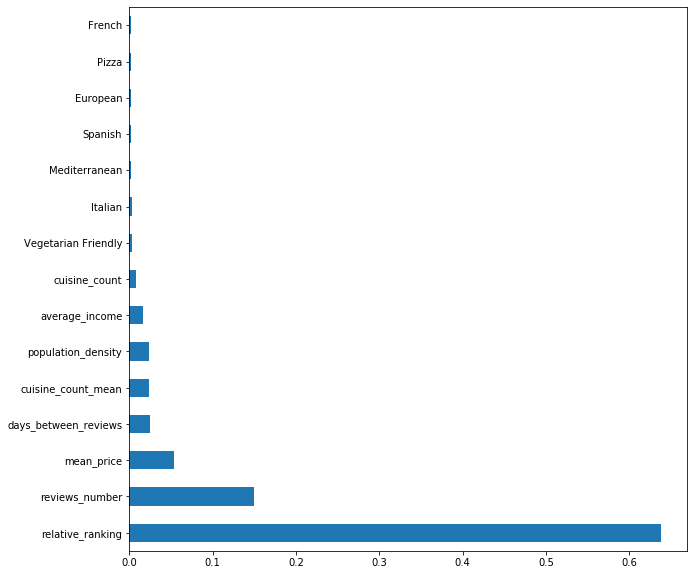

In [29]:
plt.figure(figsize=(10,10))
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')